In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [42]:
# image_size = (50, 50)
image_size = (160, 160)
image_size_rgb = image_size
# image_size_rgb = (71, 71)
batch_size = 32
image_path = "all_files"
seeds = 42
num_classes = 8
validation_s = 0.2
labels = 'inferred'
label_mode="categorical"
# label_mode="int"


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    label_mode=label_mode,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = "grayscale"
)

train_ds_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="training",
    seed=seeds,
    label_mode=label_mode,
    image_size=image_size_rgb,
    batch_size=batch_size
)
val_ds_rgb = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    labels=labels,
    validation_split=validation_s,
    subset="validation",
    seed=seeds,
    label_mode=label_mode,
    image_size=image_size_rgb,
    batch_size=batch_size
)

Found 2996 files belonging to 8 classes.
Using 2397 files for training.
Found 2996 files belonging to 8 classes.
Using 599 files for validation.
Found 2996 files belonging to 8 classes.
Using 2397 files for training.
Found 2996 files belonging to 8 classes.
Using 599 files for validation.


tf.Tensor(
[[[133.5905 ]
  [135.89   ]
  [135.15   ]
  ...
  [135.     ]
  [136.     ]
  [135.     ]]

 [[135.0185 ]
  [134.11   ]
  [134.85   ]
  ...
  [135.70001]
  [134.88998]
  [135.61697]]

 [[135.2125 ]
  [133.9725 ]
  [137.     ]
  ...
  [135.85   ]
  [135.     ]
  [134.8425 ]]

 ...

 [[216.26   ]
  [222.11   ]
  [227.9125 ]
  ...
  [214.99997]
  [214.13013]
  [234.82494]]

 [[221.26996]
  [224.17549]
  [229.9925 ]
  ...
  [224.07246]
  [222.55008]
  [236.54845]]

 [[229.92052]
  [231.14001]
  [234.95502]
  ...
  [232.74748]
  [228.58014]
  [234.1089 ]]], shape=(50, 50, 1), dtype=float32)


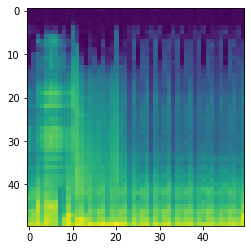

In [43]:
image, label = next(iter(train_ds))
image = image[0]
print(image)
_ = plt.imshow(image)

Min and max pixel values: 0.039450884 0.9058825


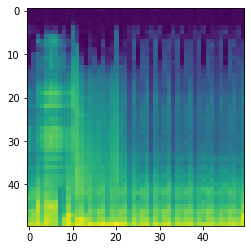

In [44]:
rescale = tf.keras.Sequential([
  layers.Rescaling(scale=1.0 / 127.5, offset=-1)
  # layers.Rescaling(scale=1.0 / 255)
])

result = rescale(image)

plt.imshow(image)
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

tf.Tensor(
[[-0.19765091 -0.19827443 -0.186647   ... -0.18980396 -0.18690228
  -0.18532944]
 [-0.20518816 -0.2056039  -0.19849014 ... -0.17764693 -0.1987449
  -0.2008633 ]
 [-0.2049411  -0.20437247 -0.18617642 ... -0.1926471  -0.20678383
  -0.1814115 ]
 ...
 [ 0.6197648   0.67258835  0.51333344 ...  0.54705894  0.6553335
   0.6728431 ]
 [ 0.667796    0.6949023   0.5902548  ...  0.6396071   0.70415723
   0.7296467 ]
 [ 0.8265884   0.7803923   0.7172941  ...  0.76862705  0.7345526
   0.8380394 ]], shape=(50, 50), dtype=float32)


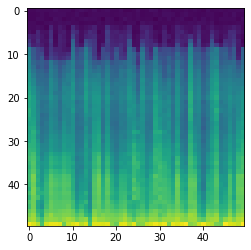

In [45]:
buffer_size = 32

aug_ds = train_ds.map(
  lambda x, y: (rescale(x, training=True), y))


image2, label = next(iter(aug_ds))
image2 = image2[0]
print(image2)
_ = plt.imshow(image2)

# train_ds = train_ds.shuffle(buffer_size=buffer_size)
# # val_ds = val_ds.shuffle(buffer_size=buffer_size)

# aug_ds = train_ds.prefetch(buffer_size=buffer_size)
# val_ds = val_ds.prefetch(buffer_size=buffer_size)

Min and max pixel values: 116 242
Min and max pixel values: 107 239
Min and max pixel values: 115 247
Min and max pixel values: 94 246
Min and max pixel values: 106 242
Min and max pixel values: 108 241
Min and max pixel values: 97 233
Min and max pixel values: 107 239
Min and max pixel values: 131 241


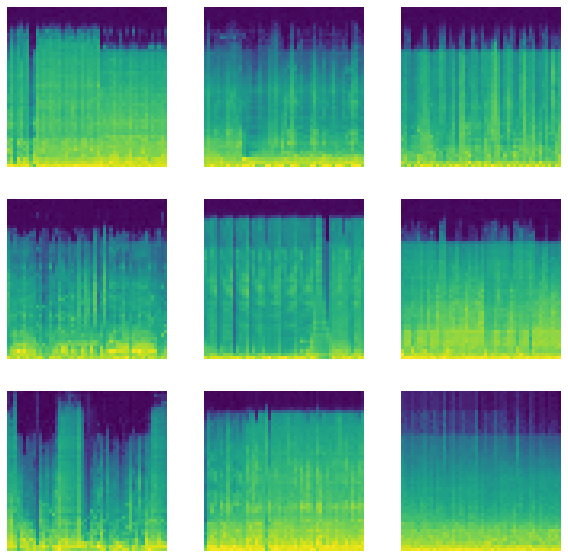

In [46]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        helper1 = images[0][i].numpy().astype("uint8")
        print("Min and max pixel values:", helper1.min(), helper1.max())
        plt.imshow(helper1)
        # plt.title(int(labels[i]))
        plt.axis("off")

In [47]:
## Model parameters:
main_activation = "relu"
last_activation = "softmax"
bias = True
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
initializer = None
rescaling_layer = layers.Rescaling(scale=1.0 / 255)
# rescaling_layer = layers.Rescaling(scale=1.0 / 127.5, offset=-1)

In [48]:
def make_model_DNN(input_shape, num_classes):
    model = keras.models.Sequential()
    
    # model.add(layers.Rescaling(1.0 / 255))
    model.add(rescaling_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    # model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    # model.add(layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias))
    model.add(layers.Dense(num_classes, activation=last_activation))
    return model

model_DNN = make_model_DNN(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model_DNN, show_shapes=True)

In [49]:
# def make_model_bas(input_shape, num_classes):
#     initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
#     model = keras.models.Sequential()
#     model.add(layers.Rescaling(1.0 / 255))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_initializer=initializer,use_bias=True))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(32, activation='sigmoid',kernel_initializer=initializer,use_bias=True))
#     model.add(layers.Dense(num_classes))
#     return model

# model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# # keras.utils.plot_model(model, show_shapes=True)
# # model_bas.summary()

In [50]:
def make_model_bas(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    x = rescaling_layer(inputs)
    x = layers.Conv2D(32, (3, 3), activation=main_activation, input_shape=input_shape,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(32, activation=main_activation,kernel_initializer=initializer,use_bias=bias)(x)

    x = layers.Dense(32, activation=last_activation,kernel_initializer=initializer,use_bias=bias)(x)
    
    outputs = layers.Dense(num_classes)(x)
    return keras.Model(inputs, outputs)

model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
# keras.utils.plot_model(model, show_shapes=True)
model_bas.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 50, 50, 1)         0         
                                                                 
 conv2d_66 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 22, 22, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                     

In [51]:
def make_model_adv(input_shape, num_classes, chanels=3):
    inputs = keras.Input(shape=input_shape)
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
    initializer = None
    # Entry block
    # x = layers.Rescaling(1.0 / 255)(inputs)
    x = rescaling_layer(inputs)
    # x = layers.Conv2D(32, chanels, strides=2, padding="same")(x)
    x = layers.Conv2D(32, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    # x = layers.Conv2D(64, chanels, padding="same")(x)
    x = layers.Conv2D(64, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
    # for size in [128, 256]:
        x = layers.Activation(main_activation)(x)
        # x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.SeparableConv2D(size, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(main_activation)(x)
        # x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.SeparableConv2D(size, chanels, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # residual = layers.Conv2D(size, chanels, strides=2, padding="same")(
        #     previous_block_activation
        # )
        residual = layers.Conv2D(size, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=bias)(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation=main_activation)(x)

    # if num_classes == 2:
    #     activation = "sigmoid"
    #     units = 1
    # else:
    #     activation = "softmax"
    #     units = num_classes
    
    units = num_classes

    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units, activation=last_activation, kernel_initializer=initializer,use_bias=True)(x)
    # outputs = layers.Dense(units, activation=activation,kernel_initializer=initializer,use_bias=True)(x)
    return keras.Model(inputs, outputs)


model_adv = make_model_adv(input_shape=image_size + (1,), num_classes=num_classes,chanels=1)
# keras.utils.plot_model(model_adv, show_shapes=True)
model_adv.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 rescaling_8 (Rescaling)        (None, 50, 50, 1)    0           ['input_23[0][0]']               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   64          ['rescaling_8[1][0]']            
                                                                                                  
 batch_normalization_78 (BatchN  (None, 25, 25, 32)  128         ['conv2d_69[0][0]']              
 ormalization)                                                                             

In [52]:
def make_model_adv_bas(input_shape, num_classes, chanels=3):
    inputs = keras.Input(shape=input_shape)
    # initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
    initializer = None
    # Entry block
    x = rescaling_layer(inputs)
    x = layers.Conv2D(32, chanels, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.Conv2D(64, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
    # for size in [128, 256]:
        x = layers.Activation(main_activation)(x)
        x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation(main_activation)(x)
        x = layers.SeparableConv2D(size, chanels, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, chanels, strides=2, padding="same")(
            previous_block_activation
        )
        # residual = layers.Conv2D(size, chanels, strides=2, padding="same",kernel_regularizer='l2',kernel_initializer=initializer,use_bias=True)(
        #     previous_block_activation
        # )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, chanels, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(main_activation)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation=main_activation)(x)

    # if num_classes == 2:
    #     activation = "sigmoid"
    #     units = 1
    # else:
    #     activation = "softmax"
    #     units = num_classes
    
    units = num_classes

    # x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(units, activation=last_activation,use_bias=True)(x)
    # outputs = layers.Dense(units, activation=activation,kernel_initializer=initializer,use_bias=True)(x)
    return keras.Model(inputs, outputs)


model_adv_bas = make_model_adv_bas(input_shape=image_size + (1,), num_classes=num_classes,chanels=1)
# keras.utils.plot_model(model_adv, show_shapes=True)
model_adv.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 rescaling_8 (Rescaling)        (None, 50, 50, 1)    0           ['input_23[0][0]']               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   64          ['rescaling_8[1][0]']            
                                                                                                  
 batch_normalization_78 (BatchN  (None, 25, 25, 32)  128         ['conv2d_69[0][0]']              
 ormalization)                                                                             

In [53]:
def make_model_im_net(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  inputs = layers.Rescaling(1.0 / 255)(inputs)

  input_shape_rgb = (input_shape[0], input_shape[1], 3)

  base_model = tf.keras.applications.Xception(input_shape = input_shape_rgb,
                                          include_top=False,
                                          weights='imagenet'
                                          
                                          )

  base_model.trainable = False

  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  # x = layers.Dropout(0.1)(x)
  x = layers.Dense(512, activation="relu", use_bias=True)(x)
  x = layers.Dense(64, activation="softmax", use_bias=True)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs,outputs)

model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)
# model_im_net.summary()

# keras.utils.plot_model(model_im_net, show_shapes=True)

****Modell fitting and validating****

In [54]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

In [55]:
epochs = 30
# l_r = 0.0005



def modell_fit_val(models,model_names,l_r = 0.001,chanels = 1):
    if chanels == 1:
        fit_train_ds = train_ds
        fit_val_ds = val_ds
    elif chanels == 3:
        fit_train_ds = train_ds_rgb
        fit_val_ds = val_ds_rgb

    #compile parameters
    opt = keras.optimizers.Adam(learning_rate=l_r)
    batch_size = 32
    loss = tf.keras.losses.CategoricalCrossentropy()

    models_test_acc = []
    for models, model_name in zip(models,model_names):

        save_dir = "saves/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + model_name + "_" + str(l_r)
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)       
        reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=4, min_delta=0.01,
            verbose=1
        )
        callbacks = [
        keras.callbacks.ModelCheckpoint(save_dir + "_{epoch}.h5"),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        reducelr_callback]

        print("Training model: {} with learning rate: {}".format(model_name,l_r))

        models.compile(
            # optimizer=keras.optimizers.Adam(),
            optimizer=opt,
            loss=loss,
            metrics=["accuracy"]
        )
        models.fit(
            fit_train_ds, batch_size=batch_size, epochs=epochs, callbacks=callbacks, 
            validation_data=fit_val_ds, shuffle=True
        )
        test_loss, test_acc = models.evaluate(fit_val_ds, verbose=2)
        models_test_acc.append(test_acc)

    for counter, acc in enumerate(models_test_acc):
        print("the {}. model has an accuracyŰ of {}".format(counter,acc))

In [56]:
# modell_fit_val([model_DNN],"model_DNN",0.01)

In [57]:
for l_rate in [0.1,0.01,0.001,0.0001]:
    model_DNN = make_model_DNN(input_shape=image_size + (1,), num_classes=num_classes)
    model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
    modell_fit_val([model_DNN,model_bas],['model_DNN','model_bas'],l_r=l_rate)

Training model: model_DNN with learning rate: 0.1
Epoch 1/30
75/75 [==============================] - 2s 20ms/step - loss: 13.0177 - accuracy: 0.1781 - val_loss: 2.0324 - val_accuracy: 0.1903 - lr: 0.1000
Epoch 2/30
75/75 [==============================] - 2s 21ms/step - loss: 1.9951 - accuracy: 0.2044 - val_loss: 2.0425 - val_accuracy: 0.1903 - lr: 0.1000
Epoch 3/30
75/75 [==============================] - 2s 19ms/step - loss: 1.9995 - accuracy: 0.2023 - val_loss: 2.0362 - val_accuracy: 0.1903 - lr: 0.1000
Epoch 4/30
75/75 [==============================] - 1s 18ms/step - loss: 1.9981 - accuracy: 0.1944 - val_loss: 2.0452 - val_accuracy: 0.1903 - lr: 0.1000
Epoch 5/30
65/75 [=========================>....] - ETA: 0s - loss: 2.0012 - accuracy: 0.1865
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
75/75 [==============================] - 1s 14ms/step - loss: 1.9976 - accuracy: 0.1948 - val_loss: 2.0562 - val_accuracy: 0.1903 - lr: 0.1000
Epoch 6/30
75/75 [

KeyboardInterrupt: 

In [ ]:
for l_rate in [1,0.1,0.01,0.001,0.0001]:
    model_bas = make_model_bas(input_shape=image_size + (1,), num_classes=num_classes)
    model_adv_bas = make_model_adv_bas(input_shape=image_size + (1,), num_classes=num_classes)
    model_adv = make_model_adv(input_shape=image_size + (1,), num_classes=num_classes)
    modell_fit_val([model_bas,model_adv_bas,model_adv],['model_bas','model_adv_bas','model_adv'],l_r=l_rate)

Training model: model_bas with learning rate: 1
Epoch 1/30
42/75 [===============>..............] - ETA: 1s - loss: 2.0963 - accuracy: 0.2068

KeyboardInterrupt: 

In [ ]:
# modell_fit_val([model_bas],"model_bas")

In [ ]:
# modell_fit_val([model_adv],"model_adv")

In [58]:
model_im_net = make_model_im_net(input_shape=image_size_rgb + (3,), num_classes=num_classes)
modell_fit_val([model_im_net],"model_im_net",chanels=3)

Training model: m with learning rate: 0.001
Epoch 1/30
75/75 [==============================] - 24s 297ms/step - loss: 2.0394 - accuracy: 0.2040 - val_loss: 2.0422 - val_accuracy: 0.1903 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - 23s 301ms/step - loss: 2.0244 - accuracy: 0.2065 - val_loss: 2.0338 - val_accuracy: 0.1903 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - 24s 315ms/step - loss: 2.0146 - accuracy: 0.2065 - val_loss: 2.0285 - val_accuracy: 0.1903 - lr: 0.0010
Epoch 4/30
16/75 [=====>........................] - ETA: 11s - loss: 2.0101 - accuracy: 0.1895

KeyboardInterrupt: 

In [ ]:
def model_saver(models,names,path):
    for model, name in zip(models,names):
        model.save(os.path.join(path,name))

In [ ]:
# model_saver([model_im_net,model_adv],["model_im_net","model_adv"],"/home/vikichan/Documents/ta_labor/tester/modells/01_14/")